<a href="https://colab.research.google.com/github/mrmattuschka/DeePiCt/blob/colab_notebook/DeePiCt_predict3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeePiCt 3D U-Net segmentation

Description for what is this Colab notebook, and how to use it ...

## Step 1. Installations
___

1. Get the git repository







In [ ]:
!git clone https://github.com/mrmattuschka/DeePiCt.git

2. Install required packages

In [ ]:
!pip install mrcfile
!pip install tensorboardX

3. Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 2. Set the data variables and config file

___

1. Create variables 

> Define the following information in the given variables:
*   **tomo_name** - ID/name for the tomogram
*   **user_config_file** - path where to save the config yaml file (created next)
*   **user_data_file** - path where to save the data csv file (created next)
*   **user_prediction_folder** - path to folder where to save prediction files
*   **user_work_folder** - path to folder where to save intermediate files


In [ ]:
scriptdir = '/content/DeePiCt/3d_cnn/scripts'
srcdir = '/content/DeePiCt/3d_cnn/src/'
original_config_file = '/content/drive/MyDrive/tomo_data/full_vpp_net_config1.yaml'
model_path = '/content/drive/MyDrive/tomo_data/full_vpp_ribo_model_IF4_D2_BN.pth'
target_spectrum_path = '/content/drive/MyDrive/tomo_data/spectrum.tsv'

# Define the folowing variables:
tomo_name = 'TS_045_rec'
user_config_file = '/content/config.yaml'
user_data_file = '/content/data.csv'
user_prediction_folder = '/content/drive/MyDrive/tomo_data/predictions/'
user_work_folder = '/content/work/'

2. Create data csv file



> Define the following information in the `data` list for the tomogram of interest:
*   **tomo_name** - ID/name for the tomogram
*   **raw_tomo** - path to the raw tomogram
*   **filtered_tomo** - path to the filtered tomogram
*   **x_dim** - dimension on x axis
*   **y_dim** - dimension on y axis
*   **z_dim** - dimention on z axis
*   **no_mask** -




In [ ]:
import csv

header = ['tomo_name','raw_tomo','filtered_tomo','x_dim','y_dim','z_dim', 'no_mask']

# Define the elements of this list:
data = ['TS_045_rec','/content/drive/MyDrive/tomo_data/TS_045_rec.mrc','/content/drive/MyDrive/tomo_data/TS_045_filtered.mrc', 256, 256, 500,'']

with open(user_data_file, 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write the data
    writer.writerow(data)
  
data_dictionary = dict(zip(header, data))

3. Create yaml config file

In [ ]:
import yaml

def read_yaml(file_path):
    with open(file_path, "r") as stream:
        data = yaml.safe_load(stream)
    return data

def save_yaml(data, file_path):
    with open(file_path, 'w') as yaml_file:
        yaml.dump(data, yaml_file, default_flow_style=False)

d = read_yaml(original_config_file)
d['dataset_table'] = user_data_file
d['output_dir'] = user_prediction_folder
d['work_dir'] = user_work_folder
d['model_path'] = f'{model_path}'
d['tomos_sets']['training_list'] = []
d['tomos_sets']['prediction_list'] = f'[{tomo_name}]'
d['cross_validation']['active'] = False
d['training']['active'] = False
d['prediction']['active'] = True
d['evaluation']['particle_picking']['active'] = False
d['evaluation']['segmentation_evaluation']['active'] = False
d['training']['processing_tomo'] = 'filtered_tomo'
d['prediction']['processing_tomo'] = 'filtered_tomo'
save_yaml(d, user_config_file)

## Step 3. Preprocess the tomogram

___

1. Set Python path variable to the 3d_cnn src module 

In [ ]:
%set_env PYTHONPATH=/content/DeePiCt/3d_cnn/src:/env/python
!echo $PYTHONPATH

env: PYTHONPATH=/content/DeePiCt/3d_cnn/src:/env/python
/content/DeePiCt/3d_cnn/src:/env/python


In [ ]:
%cd /content/DeePiCt/3d_cnn/src

/content/DeePiCt/3d_cnn/src


2. Preprocess the tomogram

In [ ]:
!python /content/DeePiCt/3d_cnn/scripts/generate_prediction_partition.py --config_file {user_config_file} --pythonpath '/content/DeePiCt/3d_cnn/src' --tomo_name {tomo_name}

## Step 4. Predict with trained neural network

___

1. Segment the patches

In [ ]:
!python /content/DeePiCt/3d_cnn/scripts/segment.py --config_file {user_config_file} --pythonpath '/content/DeePiCt/3d_cnn/src' --tomo_name {tomo_name} --gpu 0

2. Assemble the patches

In [ ]:
!python /content/DeePiCt/3d_cnn/scripts/assemble_prediction.py --config_file {user_config_file} --pythonpath '/content/DeePiCt/3d_cnn/src' --tomo_name {tomo_name}

## Step 5. Post-processing of the prediction

___



In [ ]:
!python /content/DeePiCt/3d_cnn/scripts/clustering_and_cleaning.py --config_file {user_config_file} --pythonpath '/content/DeePiCt/3d_cnn/src' --tomo_name {tomo_name}

Processing tomo TS_045_rec
file in .mrc format
tcmalloc: large alloc 1781768192 bytes == 0x55d28d166000 @  0x7f5834add1e7 0x55d28578c578 0x55d285847200 0x55d285846c5e 0x55d2857996d4 0x55d285759b32 0x55d2857cd1dd 0x55d28575a9da 0x55d2857c9108 0x55d28575a9da 0x55d2857c9108 0x55d2857c802f 0x55d28575aaba 0x55d2857cd2c0 0x55d2857c81c0 0x55d28575aaba 0x55d2857c9108 0x55d2857c81c0 0x55d28575b36c 0x55d28579c7b9 0x55d2857996d4 0x55d285759c29 0x55d2857cde61 0x55d2857c802f 0x55d28575aaba 0x55d2857cd2c0 0x55d2857c802f 0x55d28575aaba 0x55d2857c9cd4 0x55d2857c802f 0x55d28575aaba
tcmalloc: large alloc 3563520000 bytes == 0x55d311d6e000 @  0x7f5834add1e7 0x7f5831f7e46e 0x7f5831fcec7b 0x7f5831fced18 0x7f583208ad79 0x7f583208de4c 0x7f58321ace7f 0x7f58321b2fb5 0x7f58321b4e3d 0x7f58321b6516 0x55d28575a600 0x55d28575a1d9 0x7f5832094e6b 0x55d2858433a8 0x55d2857c9fc8 0x55d2857c802f 0x55d2857c7d43 0x55d285892302 0x55d28589267d 0x55d285892526 0x55d28586a1d3 0x55d285869e7c 0x7f58338c7bf7 0x55d285869d5a
Region m

***NOTE:*** if the previous command is failing because of memory error, try this slower version:

In [ ]:
!python /content/DeePiCt/3d_cnn/scripts/clustering_and_cleaning_slower.py --config_file {user_config_file} --pythonpath '/content/DeePiCt/3d_cnn/src' --tomo_name {tomo_name}

Processing tomo TS_045_rec
file in .mrc format
tcmalloc: large alloc 1781768192 bytes == 0x562ae265c000 @  0x7f1c642dd1e7 0x562adb9e6578 0x562adbaa1200 0x562adbaa0c5e 0x562adb9f36d4 0x562adb9b3b32 0x562adba271dd 0x562adb9b49da 0x562adba23108 0x562adb9b49da 0x562adba23108 0x562adba2202f 0x562adb9b4aba 0x562adba272c0 0x562adba221c0 0x562adb9b4aba 0x562adba23108 0x562adba221c0 0x562adb9b536c 0x562adb9f67b9 0x562adb9f36d4 0x562adb9b3c29 0x562adba27e61 0x562adba2202f 0x562adb9b4aba 0x562adba272c0 0x562adba2202f 0x562adb9b4aba 0x562adba23cd4 0x562adba2202f 0x562adb9b4aba
tcmalloc: large alloc 3563520000 bytes == 0x562b67264000 @  0x7f1c642dd1e7 0x7f1c6177e46e 0x7f1c617cec7b 0x7f1c617ced18 0x7f1c6188ad79 0x7f1c6188de4c 0x7f1c619ace7f 0x7f1c619b2fb5 0x7f1c619b4e3d 0x7f1c619b6516 0x562adb9b4600 0x562adb9b41d9 0x7f1c61894e6b 0x562adba9d3a8 0x562adba23fc8 0x562adba2202f 0x562adba21d43 0x562adbaec302 0x562adbaec67d 0x562adbaec526 0x562adbac41d3 0x562adbac3e7c 0x7f1c630c7bf7 0x562adbac3d5a
Region m

# Step 6. Visualize results

___

In [ ]:
import mrcfile


def read_tomogram(filename):
    with mrcfile.open(filename, permissive=True) as m:
        return m.data

1. Read the tomogram and the prediction

In [ ]:
tomogram = read_tomogram(data_dictionary['filtered_tomo'])
path = f"{d['output_dir']}/predictions/{d['model_path'].split('/')}"
predictions = read_tomogram('/content/predictions/predictions/full_vpp_ribo_model_IF4_D2_BN/TS_045_rec/ribo/post_processed_prediction.mrc')

2. Visualize the prediction

> Define the z axis for visualization (variable `z_axis`)



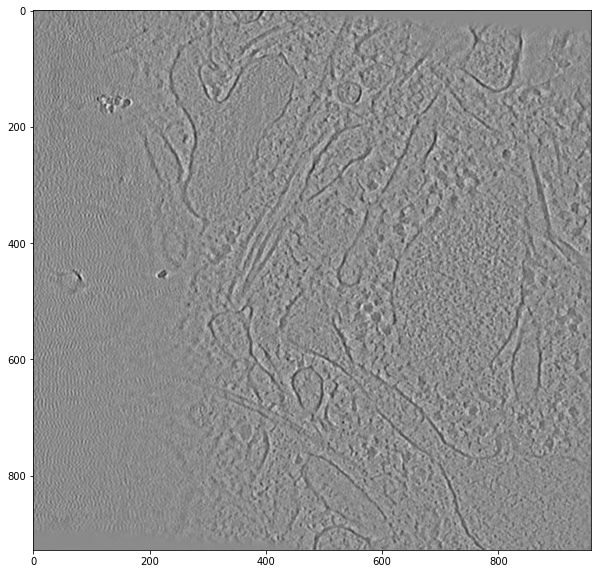

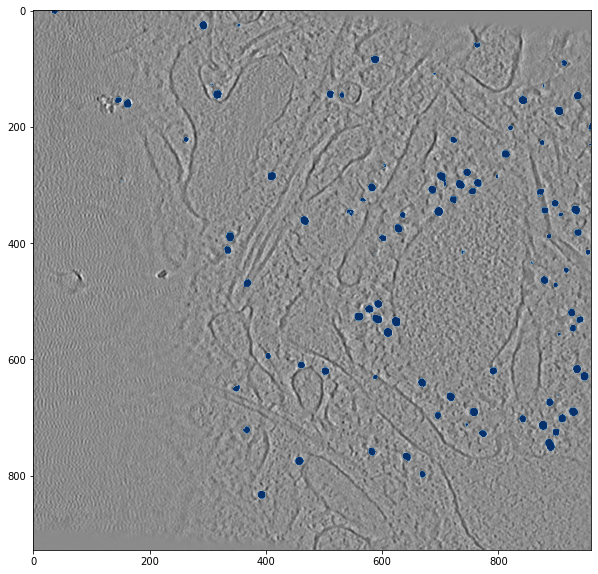

In [ ]:
z_axis = 200

import numpy as np
import matplotlib.pyplot as plt

# First figure
plt.figure(figsize = (10,10))
plt.imshow(tomogram[z_axis], cmap='gray')

# Second figure
plt.figure(figsize = (10,10))
plt.imshow(tomogram[z_axis], cmap='gray')
alphas = np.zeros(predictions.shape)
alphas[predictions > 0] = 1
plt.imshow(predictions[z_axis], alpha=alphas[z_axis], cmap='Blues')